In [1]:

! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd


In [3]:
from google.colab import drive
drive.mount("/content/drive") 


Mounted at /content/drive


In [4]:
path="/content/df_all.csv"

In [5]:
df= pd.read_csv(path)

In [6]:
df.head()

,Unnamed: 0,text,class
0,8,rt crooked hillary you didn't lose because yo...,explicit_hate
1,9,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,34,are a bunch of religious bigots . i hope you e...,explicit_hate
3,45,hamas is the only one who lies and all those l...,explicit_hate
4,65,one of the questions never asked : if africans...,explicit_hate


In [ ]:
#df2 = df.sample(frac=0.20) 

In [7]:
df.shape

(64875, 3)

In [8]:
category_count = df['class'].value_counts()

categories = category_count.index

categories

Index(['not_hate', 'offensive', 'implicit_hate', 'explicit_hate'], dtype='object')

In [9]:
import matplotlib.pyplot as plt

In [10]:

import seaborn as sns

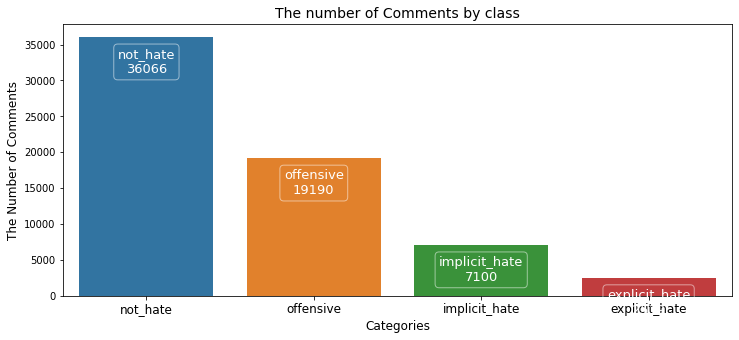

In [11]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 12)

plt.ylabel('The Number of Comments', size= 12)

plt.xticks(size = 12)

plt.title("The number of Comments by class" , size = 14)

plt.show()

In [ ]:
#hate=1 not_hate=0

In [12]:
df = df.dropna()

In [ ]:
#df['text_cleaned'] = df['text'].str.replace('@[A-Za-z0-9]+\s?','', regex=True)

In [ ]:
#df['class_encoded'] = df['class'].astype('category').cat.codes
#df.head()

In [13]:

# Replace classes 
df['class'] = np.where((df['class'] == 'not_hate'), 0, df['class'])
df['class'] = np.where((df['class'] == 'explicit_hate'), 1, df['class'])
df['class'] = np.where((df['class'] == 'implicit_hate'), 1, df['class'])
df['class'] = np.where((df['class'] == 'offensive'), 1, df['class'])

# show head 
df.head()

,Unnamed: 0,text,class
0,8,rt crooked hillary you didn't lose because yo...,1
1,9,"rt estonian pm : "" i don't want blacks in es...",1
2,34,are a bunch of religious bigots . i hope you e...,1
3,45,hamas is the only one who lies and all those l...,1
4,65,one of the questions never asked : if africans...,1


In [14]:
X=list(df['text'])
#X=list(df['text_cleaned'])

In [15]:
y=list(df['class'])

In [ ]:
#y=list(pd.get_dummies(y,drop_first=True)['not_hate'])

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

In [17]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [18]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)


In [19]:
#convert it in to dataset object for tensorflow
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))



In [20]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps = 10
    )

In [21]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [22]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.2502892011477623}

In [ ]:
#trainer.predict(test_dataset)

In [23]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)

In [ ]:
output.shape

In [24]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,output)
cm

array([[6633,  554],
       [ 731, 5040]])

In [25]:

pd.DataFrame(output).to_csv('output.csv') 

In [ ]:

pd.DataFrame(y).to_csv('y.csv') 

In [ ]:

pd.DataFrame(X).to_csv('X.csv') 

In [ ]:
trainer.save_model('senti_model')

In [26]:
# model's performance
print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7187
           1       0.90      0.87      0.89      5771

    accuracy                           0.90     12958
   macro avg       0.90      0.90      0.90     12958
weighted avg       0.90      0.90      0.90     12958

